# Task1
## High Level State Representation
- Data is generated by an "expert" player.
- $timeout -sHUP 30m python ./lunar_lander_data_gen.py
    - generates data for 10 minutes
    - saves high level state representation as state_vectors_*.csv
    - saves low level state representatio (image files) in ./frames/
- Train and evaluate a number of supervised machine learning models to predict actions of an "expert" player


- Model saved as:
    - ml_states_player.pkl
    

- Process: CRISP-DM
    - Iterating over this workflow
    - Assessing data, modeling, evaluating, re-developing
    - e.g. Strong accuracies, but poor flight from imbalanced dataset 
            -> undersampling
    - e.g. Initial learning curves implied immature models 
            -> generate more data.
    

## Imports

In [1]:
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import cross_val_score, cross_val_predict, \
                                    GridSearchCV,    train_test_split, \
                                    learning_curve,  StratifiedKFold

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.externals import joblib

from imblearn.under_sampling import RandomUnderSampler

from my_lib import topn, plot_learning_curve



### View Project Folder

In [2]:
ls

dqn_LunarLander-v2_weights.h5f     __pycache__/
frames/                            README.txt
lunar_lander_data_gen.py*          recording/
lunar_lander_dl_player.py*         rl/
lunar_lander_ml_images_player.py*  state_vectors_2018-04-21-20-41-25.csv
lunar_lander_ml_states_player.py*  Task1.ipynb
ml_states_player.pkl               Task2.ipynb
my_lib.py                          Task3.ipynb
player.mod                         Task3.py*


### Plug In Data

In [3]:

#Other User
#data_file = "state_vectors_*.csv"

#Andy
data_file = "state_vectors_2018-04-21-20-41-25.csv"

#Conor
#data_file = "../state_vectors_2018-04-20-15-12-38.csv"


### Experiment Parameters

In [4]:
#Sample for faster processing
sample_frac = 0.10

#Stratify to preserve label weightings
grid_search_cv_folds = StratifiedKFold(10, shuffle=True)
cv_experiment_folds = StratifiedKFold(10, shuffle=True)
learning_curve_folds = StratifiedKFold(5, shuffle=True)

### Prepare Dataset
- Undersampled to balance classes.
    - A very important/infrequent actions are stabalizer engines.
- Sampling Dataset to improve processing time.
    - Tune with medium amount of data for find generalizable parameters

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38484 entries, 0 to 73
Data columns (total 8 columns):
pos_x                      38484 non-null float64
pos_y                      38484 non-null float64
vel_x                      38484 non-null float64
vel_y                      38484 non-null float64
ship_lander_angle          38484 non-null float64
ship_lander_angular_vel    38484 non-null float64
leg_1_ground_contact       38484 non-null float64
leg_2_ground_contact       38484 non-null float64
dtypes: float64(8)
memory usage: 3.9 MB


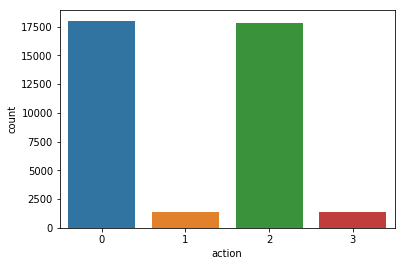

In [5]:
# load dataset for data file
df = pd.read_csv(data_file, header=0, index_col='step')

# split data into X,y (descriptive features, target feature)
X,y = df[[col for col in list(df) if col!='action']], df['action']

#view class label chart
sns.countplot(y)

#show dataframe infromation
pd.DataFrame(X).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5388 entries, 0 to 5387
Data columns (total 8 columns):
0    5388 non-null float64
1    5388 non-null float64
2    5388 non-null float64
3    5388 non-null float64
4    5388 non-null float64
5    5388 non-null float64
6    5388 non-null float64
7    5388 non-null float64
dtypes: float64(8)
memory usage: 336.8 KB


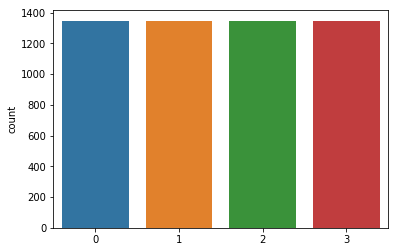

In [6]:
# Apply the random under-sampling
# DataSet is Approx 7 times smaller
rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, idx_resample = rus.fit_sample(X,y)
sns.countplot(y_rus)
pd.DataFrame(X_rus).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 8 columns):
0    269 non-null float64
1    269 non-null float64
2    269 non-null float64
3    269 non-null float64
4    269 non-null float64
5    269 non-null float64
6    269 non-null float64
7    269 non-null float64
dtypes: float64(8)
memory usage: 16.9 KB


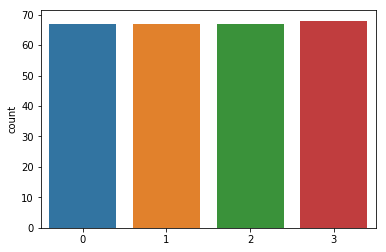

In [7]:
#TrainSample
n_samples=int(len(y_rus)*sample_frac)
X_s, _, y_s, _ = train_test_split(X_rus, y_rus, 
                                  train_size=0.05, test_size=4, stratify=y_rus, shuffle=True)
sns.countplot(y_s)
pd.DataFrame(X_s).info()


### Algorithms and Search Space
- RandomForest
    - Forest of Decision Trees each with only subset of features
    - Members tend to be "weaker" but quite diverse.
    - Ensembles non-linear, volatile classifiers
    - Flexible learner for most problems.
    - Relativly quick to train, predict and is compact in memory for most scales of data.
    - Gives good baseline for most problems
    

- Bagging Classifier
    - Forest of Decision Trees each with entire feature set available
    - Members tend to be stronger, but less diverse.
    - Similar benefits to random forest.
    

- MLP
    - Highly non-linear
    - Particularly goog at extracting non linear relationships.
    - Generally long train times.
    - Good baseline for Nueral Nets
    


In [8]:
# list of chosen classifiers.
clfs = [RandomForestClassifier, MLPClassifier, BaggingClassifier]

# dictionary for grid search parameters
param_grids= {
    'RandomForestClassifier': {
        'criterion' : ['gini', 'entropy'],
        'n_estimators' : [10,15,20],
        'max_features' : [None, 5, 8]
    },
    'MLPClassifier': {
        'activation' : ['relu',],
        'hidden_layer_sizes' : [(8,8), (16,16), (128,), (256,)],
        'solver' : ['adam'],
        'learning_rate' : ['adaptive', 'constant'],
        'early_stopping' : [True]
    },
    'BaggingClassifier' : {
        'n_estimators' : [5,10,15,20],
        'max_samples' : [0.5,0.75,1],
        'max_features' : [0.5,0.75,1]
    }
}

### Execute Search

In [9]:
%%time
#store the best params and scores for each classifier
stored_grid_searches={}

# running grid search for each classifier
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    current_GS = GridSearchCV(clf(), 
                              param_grids[clf_name],
                              cv=grid_search_cv_folds,
                              verbose=0, 
                              return_train_score=True).fit(X_s,y_s)
    
    # store grid search object for each classifier
    stored_grid_searches[clf_name]=current_GS

CPU times: user 26.4 s, sys: 338 ms, total: 26.8 s
Wall time: 25.7 s


### Inspect Search Results

- GridSearch results are double checked
- Models are considered on train/prediction times and accuracy.
- In each case, the best params were judged to be those identified by the grid search.

In [10]:
#store selcted params for each classifier
selected_params={}
    

In [11]:
#print top3 results
RF_GS = stored_grid_searches['RandomForestClassifier']
topn(RF_GS, 3).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_features,param_n_estimators,params,rank_test_score,split0_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
17,0.107,0.002,0.677,0.997,entropy,8,20,"{'criterion': 'entropy', 'n_estimators': 20, '...",1,0.643,...,0.64,0.996,0.625,0.996,0.667,1.000,0.050,0.0,0.055,0.002
2,0.049,0.002,0.669,0.994,gini,None,20,"{'criterion': 'gini', 'n_estimators': 20, 'max...",2,0.714,...,0.64,0.992,0.500,0.996,0.625,0.992,0.003,0.0,0.069,0.002
15,0.040,0.001,0.669,0.979,entropy,8,10,"{'criterion': 'entropy', 'n_estimators': 10, '...",2,0.714,...,0.48,0.984,0.583,0.963,0.583,0.971,0.001,0.0,0.085,0.009


In [12]:
print("best params:", RF_GS.best_params_)
print("best score:", RF_GS.best_score_)

#store best random forest
selected_params['RandomForestClassifier'] = RF_GS.best_params_

best params: {'criterion': 'entropy', 'n_estimators': 20, 'max_features': 8}
best score: 0.676579925651


In [13]:
#print top3 results
MLP_GS = stored_grid_searches['MLPClassifier']
topn(MLP_GS, 3).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_activation,param_early_stopping,param_hidden_layer_sizes,param_learning_rate,param_solver,params,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
6,0.020,0.0,0.379,0.425,relu,True,"(256,)",adaptive,adam,"{'activation': 'relu', 'solver': 'adam', 'lear...",...,0.36,0.361,0.292,0.400,0.375,0.535,0.005,0.0,0.118,0.088
7,0.025,0.0,0.375,0.419,relu,True,"(256,)",constant,adam,"{'activation': 'relu', 'solver': 'adam', 'lear...",...,0.36,0.467,0.500,0.494,0.375,0.490,0.014,0.0,0.106,0.120
5,0.015,0.0,0.323,0.322,relu,True,"(128,)",constant,adam,"{'activation': 'relu', 'solver': 'adam', 'lear...",...,0.32,0.230,0.250,0.159,0.250,0.380,0.007,0.0,0.087,0.101


In [14]:
print("best params:", MLP_GS.best_params_)
print("best score:",  MLP_GS.best_score_)

selected_params['MLPClassifier'] = MLP_GS.best_params_

best params: {'activation': 'relu', 'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (256,), 'early_stopping': True}
best score: 0.379182156134


In [15]:
#print top3 results
BAG_GS = stored_grid_searches['BaggingClassifier']
topn(BAG_GS, 3).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_features,param_max_samples,param_n_estimators,params,rank_test_score,split0_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
19,0.041,0.002,0.677,0.988,0.75,0.75,20,"{'n_estimators': 20, 'max_samples': 0.75, 'max...",1,0.750,...,0.68,0.971,0.750,0.980,0.792,0.992,0.001,0.0,0.089,0.008
18,0.030,0.002,0.647,0.978,0.75,0.75,15,"{'n_estimators': 15, 'max_samples': 0.75, 'max...",2,0.786,...,0.56,0.963,0.792,0.963,0.833,0.992,0.001,0.0,0.101,0.011
7,0.054,0.002,0.632,0.987,0.5,0.75,20,"{'n_estimators': 20, 'max_samples': 0.75, 'max...",3,0.786,...,0.52,0.984,0.708,0.996,0.708,0.996,0.030,0.0,0.103,0.009


In [16]:
print("best params:", BAG_GS.best_params_)
print("best score:", BAG_GS.best_score_)

selected_params['BaggingClassifier'] = BAG_GS.best_params_

best params: {'n_estimators': 20, 'max_samples': 0.75, 'max_features': 0.75}
best score: 0.676579925651


### 10xCV Experiment

In [17]:
# 10xCV on sample data using selected params
cv_scores = {}
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    params = selected_params[clf_name]
    cv_scores[clf_name] = np.mean(cross_val_score(clf(**params), X_s, y_s, cv=cv_experiment_folds)) 

# print the avg CVx10 score.
pd.DataFrame(cv_scores, [0]).round(3)

,BaggingClassifier,MLPClassifier,RandomForestClassifier
0,0.606,0.379,0.641


### Learning Curves

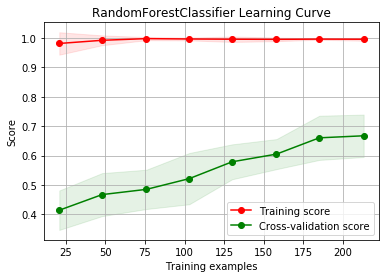

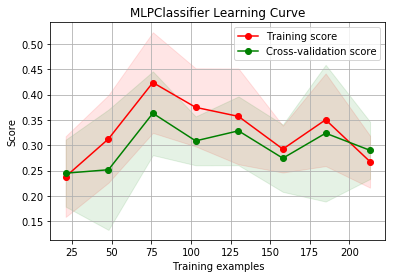

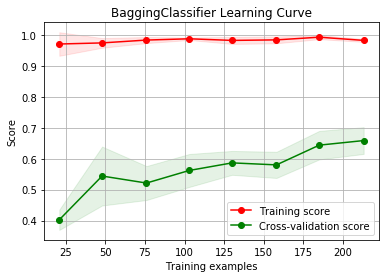

In [18]:
#Learning Curves for sample
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    params = selected_params[clf_name]
    plot_learning_curve(clf(**params), 
                        clf_name+' Learning Curve', 
                        X_s, y_s, 
                    cv=learning_curve_folds)


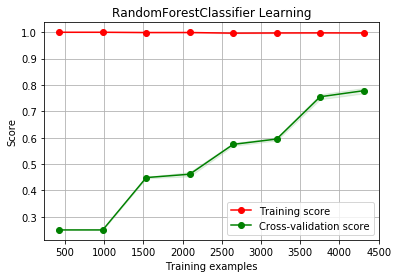

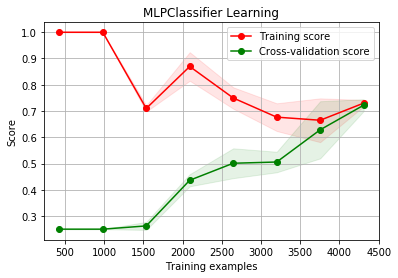

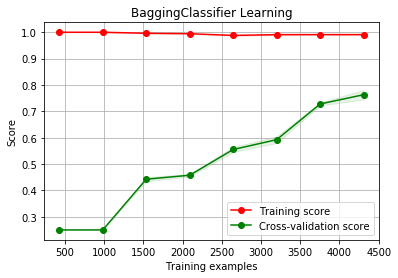

In [19]:
#Learning Curves for entire dataset
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    params = selected_params[clf_name]
    plot_learning_curve(clf(**params), 
                        clf_name+' Learning', 
                        X_rus, y_rus, 
                    cv=learning_curve_folds)


### Retrain Best Learners

In [20]:
# 10xCV on entire data using selected params
final_cv_scores={}
for clf in clfs:
    clf_name = str(clf).split(".")[-1][:-2]
    params = selected_params[clf_name]
    final_cv_scores[clf_name] = np.mean(cross_val_score(clf(**params), 
                                                        X_rus, y_rus, 
                                                        cv=cv_experiment_folds))
    
pd.DataFrame(final_cv_scores, [0]).round(3)

,BaggingClassifier,MLPClassifier,RandomForestClassifier
0,0.76,0.711,0.787


### Select Best Learner

In [21]:
#Pick best model
selected_model = MLPClassifier
model_name = str(selected_model).split(".")[-1][:-2]
params = selected_params[model_name]
model = selected_model(**params)

#train model
model.fit(X_rus, y_rus)

#verify its functioning correctly
model.predict(X_rus[:3])

#save model
filename = 'ml_states_player.pkl'
joblib.dump(model, filename)

#load model
model = joblib.load(filename)

#verify it loaded correctly
model.predict(X_rus[:3])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5388 entries, 0 to 5387
Data columns (total 8 columns):
0    5388 non-null float64
1    5388 non-null float64
2    5388 non-null float64
3    5388 non-null float64
4    5388 non-null float64
5    5388 non-null float64
6    5388 non-null float64
7    5388 non-null float64
dtypes: float64(8)
memory usage: 336.8 KB
